In [ ]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import argparse
import datetime
import graphviz
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

## other

In [ ]:
def argspace(**kwds):
  def deco(f):
    def inner(**ikwds):
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [ ]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [ ]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f, order):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(order, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      funcs = sorted(self.func[key].values(), key=lambda x: x[0])
      return [g(*args, **kwds) for _, g in funcs]
    return f

  def event(*key, order=0):
    def d(f):
      for k in key:
        Experiment()._store(k, f, order)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

## metrics

In [ ]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [ ]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [ ]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

## save

In [ ]:
def path_with_time(path : str) -> str:
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [ ]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [ ]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [ ]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  # TODO : init for mount drive
  
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [ ]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def update(self, store : 'Store'):
    self.dict.update(store.dict)

  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

# dataset

In [ ]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

In [ ]:
def load_dataloader(args):
  kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
  args.valid_size = args.valid_size if args.valid_size else 0
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.valid_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs)
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  return argparse.Namespace(train=trainloader, test=testloader, valid=validloader)

# model

## sampler

In [ ]:
class ArchitectureSampler():
  def __call__(self, graph : nx.DiGraph, alpha : torch.Tensor) -> nx.DiGraph:
    return self.graph(graph, alpha)

In [ ]:
class MaxSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      edge_num = round(sum(alphas))
      disable = sorted(zip(edges, alphas), key=lambda x: x[-1])[:-edge_num]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [ ]:
class ForwardSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if not i + 1 == j]
      G.remove_edges_from(edges)

    return G

In [ ]:
class StrideCutSampler(ArchitectureSampler):
  def __init__(self, stride_max=8):
    assert stride_max >= 1
    self.stride = stride_max

  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if G.edges[i, j]['stride'] > self.stride]
      G.remove_edges_from(edges)

    return G

In [ ]:
# model = load_model(dir="", gene='VGG19')
# g = model.graph
# sampler = StrideCutSampler(2)
# h = model.sampled_graph(sampler)
# render_graph(h, 'graph')
# # nx.graph_edit_distance(g, h)

## module

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [ ]:
class FactorizedReduce(nn.Module):
  def __init__(self, channel_in, channel_out, stride, affine=True):
    super(FactorizedReduce, self).__init__()
    assert channel_out % stride == 0
    # self.relu = nn.ReLU(inplace=False)
    self.convs = nn.ModuleList([
      nn.Conv2d(channel_in, channel_out // stride, 1, stride=stride, padding=0, bias=False)
      for _ in range(stride)
    ])
    # self.conv_1 = nn.Conv2d(channel_in, channel_out // stride, 1, stride=stride, padding=0, bias=False)
    # self.conv_2 = nn.Conv2d(channel_in, channel_out // stride, 1, stride=stride, padding=0, bias=False) 
    self.bn = nn.BatchNorm2d(channel_out, affine=affine)

  def forward(self, x):
    # x = self.relu(x)
    # strideの偶奇による情報ロスを防ぐ
    # out = torch.cat([self.conv_1(x), self.conv_2(x[:,:,1:,1:])], dim=1)
    out = torch.cat([conv(x[:,:,i:,i:]) for i, conv in enumerate(self.convs)], dim=1)
    out = self.bn(out)
    return out

In [ ]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if stride > 1:
      return FactorizedReduce(channel_in, channel_out, stride)
    elif channel_in != channel_out:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [ ]:
class Block(nn.Module):
  def __init__(self, graph, index):
    super(Block, self).__init__()
    node = graph.nodes[index]
    edges = [(i, index, graph.edges[i, index]) for i in graph.predecessors(index)]

    self.index = index
    self.indices = [i for i, _, _ in edges]
    self.edges = nn.ModuleList([self._build_module(s) for i, j, s in edges])

    process = [nn.ReLU(inplace=True)]
    if node['pool']: process += [nn.MaxPool2d(kernel_size=2, stride=2)]
    self.post_process = nn.Sequential(*process)

  def _build_module(self, setting):
    module = setting['module']
    in_channel, out_channel = setting['channel']
    stride = setting['stride']
    if module == 'forward':
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel)
          )
    elif module == 'shortcut':
      return Shortcut(in_channel, out_channel, stride)
    else:
      raise ValueError("module name")

  def forward(self, inputs, alpha):
    output = sum(alpha[i] * F(inputs[i]) for i, F in zip(self.indices, self.edges))
    return self.post_process(output)

In [ ]:
# 前提条件 : make graph, modules(Block, pool, ...)
# 拘束条件 : alpha sofmax
class Network(nn.Module):
  def __init__(self, gene, graph=None, preprocess : ArchitectureSampler=None):
    super(Network, self).__init__()
    self.gene = gene
    self.evaluate = bool(graph)
    self.graph = graph if graph else self._make_graph(gene)
    self.graph = preprocess(self.graph, None) if preprocess else self.graph

    self.blocks = nn.ModuleList(self._make_blocks(self.graph))
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _make_graph(self, gene, color_channel=3):
    
    def _decode_gene(gene):
      ch, st = [], []
      for g in gene:
        if g == 'M':
          st[-1] *= 2
        else :
          ch += [g]
          st += [1]
      return ch, st

    def __pi(array):
      r = []
      s = 1
      for q in array:
        s *= q
        r += [s]
      return r

    channel, stride = _decode_gene(gene)
    channel = [color_channel] + channel
    stride = [1] + stride
    s_stride = __pi(stride)

    n = len(channel)
    nodes = [(i, {'channel':channel[i], 'stride':s_stride[i], 'pool':stride[i]>1}) for i in range(n)]
    nodes[0][-1].update({'name':'input'})
    edges = [(i, j, {}) for i in range(n) for j in range(n) if i < j and not (i == 0 and j > 1)]
    for (i, j, d) in edges:
      d.update({
        'module' : 'forward' if i + 1 == j else 'shortcut', 
        'channel' : (nodes[i][-1]['channel'], nodes[j][-1]['channel']),
        'stride' : int(nodes[j-1][-1]['stride'] / nodes[i][-1]['stride'])
      })

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

  def _make_blocks(self, graph):
    return [Block(graph, i) for i in graph.nodes() if i > 0]

  def init_alpha(self, device):
    def _init_alpha(node_num, device, delta=1e-3):
      noise = delta * torch.randn(node_num, node_num, device=device)
      alpha = noise.clone().detach().requires_grad_(True)
      return [alpha]

    def _mask(node_num, device, name):
      mask = torch.zeros(node_num, node_num, device=device)

      for i, j in self.graph.edges():
        op = self.graph.edges[i, j]['module']
        if not op == name: continue

        mask[i, j] = 1

      return mask.t() > 0

    n = self.graph.number_of_nodes()
    self.alphas = _init_alpha(n, device)
    self.mask_s = _mask(n, device, 'shortcut')
    self.mask_f = _mask(n, device, 'forward')

    return self

  def normalized_alpha(self):
    alpha = torch.zeros_like(self.alphas[0])
    if self.evaluate:
      for i, j in self.graph.edges():
        alpha[j, i] = 1.0
    else:
      alpha[self.mask_f] = 1.0
      for a, raw, mask in zip(alpha, self.alphas[0], self.mask_s):
        a[mask] = F.softmax(raw[mask], dim=0)

      # for i, a in enumerate(alpha):
        # if i == 0: continue
        # a[1:i-1] = F.softmax(self.alphas[0][i][1:i-1], dim=0)
        # a[i-1] = 1.0
    return alpha

  def sampled_graph(self, sampler : ArchitectureSampler):
    return sampler(self.graph, self.matrix_alpha())

  @torch.no_grad()
  def matrix_alpha(self, normalize=True):
    return (self.normalized_alpha() if normalize else self.alphas[0]).t()


  def forward(self, x):
    state = [x]
    alpha = self.normalized_alpha()

    for block in self.blocks:
      x = block(state, alpha[block.index])
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

## others

In [ ]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device

  def step(self):
    data_v, target_v = next(iter(self.valid_loader))
    data_v, target_v = data_v.to(self.device), target_v.to(self.device)

    self.optimizer.zero_grad()
    output = self.model(data_v)
    loss = self.criterion(output, target_v)
    loss.backward()
    self.optimizer.step()

In [ ]:
def render_graph(graph, path):
  format = dict(
      format='png', 
      edge_attr=dict(fontsize='20', fontname="times"),
      node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
      engine='dot' # circo, dot, fdp, neato, osage, sfdp, twopi
  )

  dg = graphviz.Digraph(**format)

  dg.attr('node', fillcolor='dodgerblue4', fontcolor='white', fontsize='15') # coral, 
  for node in graph.nodes():
    attr = graph.nodes[node]
    label = attr['name'] if 'name' in attr else str(node)
    label += '\n(%s, %d, %d)' % (attr['channel'], 32 / attr['stride'], 32 / attr['stride'])
    dg.node(str(node), label=label)

  for (i, j) in graph.edges():
    attr = graph.edges[i, j]
    label = attr['module']
    label = ""
    style = 'bold' if attr['module'] == 'forward' else 'dashed'
    dg.edge(str(i), str(j), label=label, style=style)

  dg.render(path)
  return dg

# learning

## events

In [ ]:
@Experiment.event('setup')
def setup(args):
  args.save = path_with_time(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)
  logging.info('kwargs %s' % args)
  
  args.start_epoch = 0

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  args.store = store

  set_seed(args.seed)

In [ ]:
@Experiment.event('setup')
def set_device(args):
  # cuda init
  args.use_cuda = torch.cuda.is_available()
  args.device = torch.device("cuda" if args.use_cuda else "cpu")

In [ ]:
@Experiment.event('checkpoint', 'end', order=1)
def save_checkpoint(args):
  args.store.save()
  save_dir(args.save)

In [ ]:
@argspace(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    args.architect.step()

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [ ]:
@argspace()
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

## experiment

In [ ]:
@argspace(gene='VGG11', stride_max=0, graph=None, dir=None)
def load_model(args):
  
  # init
  set_device(args)
  device = args.device

  # model setup
  gene = cfg[args.gene]
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  model = Network(gene, graph=args.graph, preprocess=sampler).to(device).init_alpha(device)

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']

  return model

In [ ]:
@argspace(gene='VGG11', stride_max=0)
def main(args):

  # init
  exp = Experiment()
  exp('setup')(args)
  store = args.store
  device = args.device

  # model setup
  gene = cfg[args.gene]
  logging.info('gene %s', gene)
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  graph = args.graph if args.graph else None
  model = Network(gene, graph=graph, preprocess=sampler).to(device).init_alpha(device)

  # load cuda
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']
    args.start_epoch = state['epoch']
    store.update(state['store'])
    logging.info('Resuming from epoch %d in %s' % (args.start_epoch, args.dir))

  loader = load_dataloader(args)

  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(loader.valid, model, criterion, args.lr_alpha, device)

  @Experiment.event('checkpoint', 'end')
  def save_model(args):
    state = {
      'model': model.state_dict(),
      'graph': model.graph,
      'alpha': model.alphas,
      'store': store,
      'epoch': epoch,
    }
    torch.save(state, os.path.join(args.save, 'checkpoint.pth'))
    
  @Experiment.event('epoch_end')
  def save_graph(args):
    sampler = MaxSampler()
    graph = model.sampled_graph(sampler)
    torch.save(graph, os.path.join(args.save, 'graph_%d' % epoch + '.pth'))
    render_graph(graph, os.path.join(args.save, 'graph_%d' % epoch))


  for epoch in range(args.start_epoch + 1, args.epochs + 1):
    logging.info('epoch %d', epoch)
    logging.info('alpha %s', model.matrix_alpha())

    # training
    train_acc, train_obj = train(dataset=loader.train, model=model, 
                                 criterion=criterion, optimizer=optimizer, 
                                 architect=architect, 
                                 device=device, report_freq=args.report)
    logging.info('train_acc %f', train_acc)
    store.add("train_loss", train_obj)
    store.add("train_acc", train_acc)

    # validation
    valid_acc, valid_obj = infer(dataset=loader.test, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    logging.info('valid_acc %f', valid_acc)
    store.add("test_loss", valid_obj)
    store.add("test_acc", valid_acc)

    exp('epoch_end')(args)

    if epoch % args.checkpoint == 0:
      exp('checkpoint')(args)

  exp('end')(args)

  return model

In [ ]:
a = {"a" : 1}

def aa(**args):
  # args['a'] = 111111
  args.a = 1111
  print("aaaaaaaa")

aa(**a)
aa(a=1)

# main

In [ ]:
if __name__ == '__main__':
  main(save="exp_vgg19", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=50, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       gene='VGG19', stride_max=2,
       seed=41, report=100, checkpoint=10, dir="", graph=None)

Experiment dir : exp_vgg19_eval-2020-09-24_20-11-59
09/24 11:11:59 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=100, gene='VGG19', graph=<networkx.classes.digraph.DiGraph object at 0x7f3b61746710>, lr=0.01, lr_alpha=0.003, momentum=0.9, report=100, save='exp_vgg19_eval-2020-09-24_20-11-59', seed=41, stride_max=2, test_size=5000, train_size=25000, valid_size=25000)
09/24 11:11:59 AM gene [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
Files already downloaded and verified
Files already downloaded and verified
09/24 11:12:01 AM epoch 1
09/24 11:12:01 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,

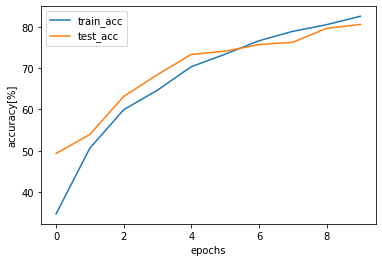

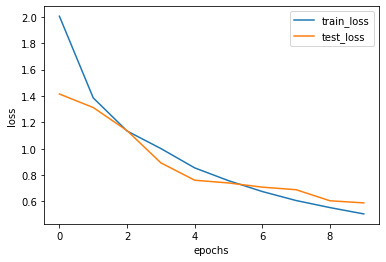

09/24 11:40:12 AM epoch 11
09/24 11:40:12 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

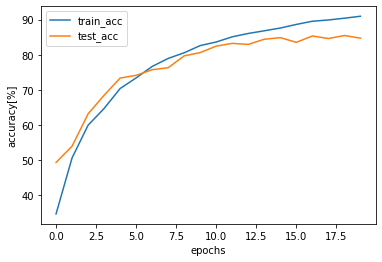

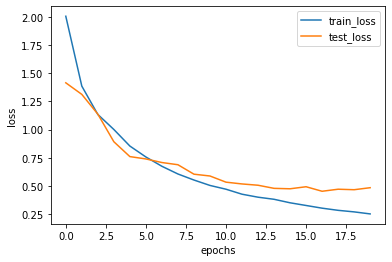

09/24 12:13:44 PM epoch 21
09/24 12:13:44 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

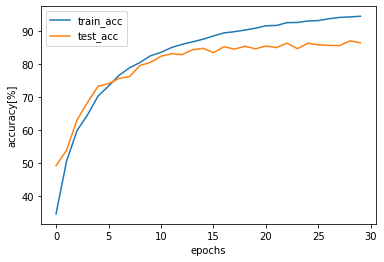

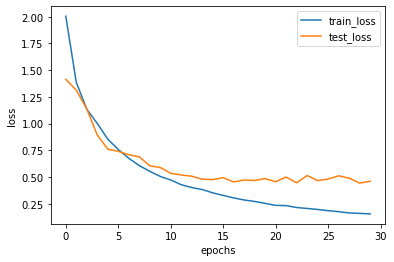

09/24 12:42:08 PM epoch 31
09/24 12:42:08 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

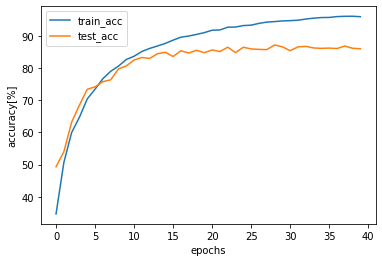

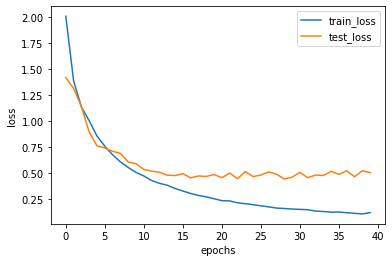

09/24 01:10:31 PM epoch 41
09/24 01:10:31 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

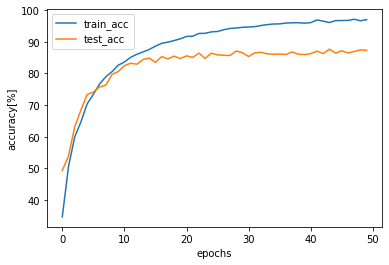

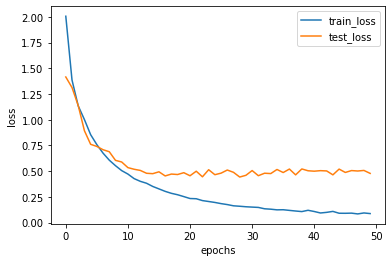

09/24 01:38:48 PM epoch 51
09/24 01:38:48 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

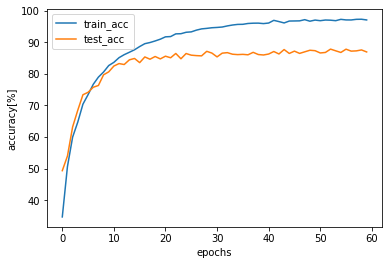

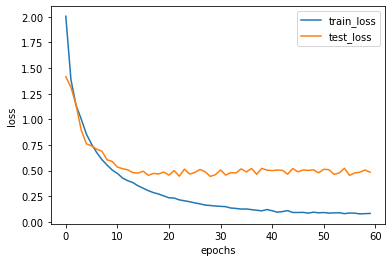

09/24 02:07:11 PM epoch 61
09/24 02:07:11 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

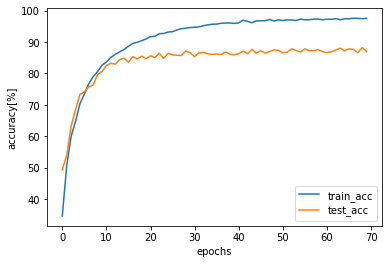

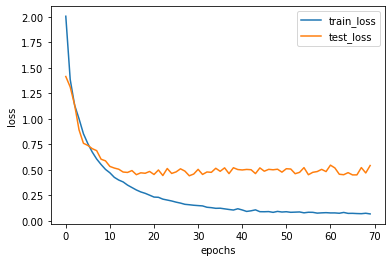

09/24 02:35:32 PM epoch 71
09/24 02:35:32 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

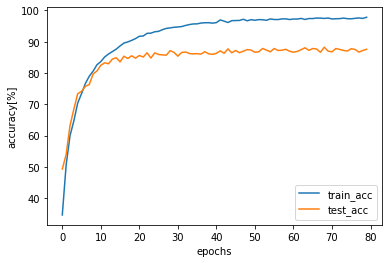

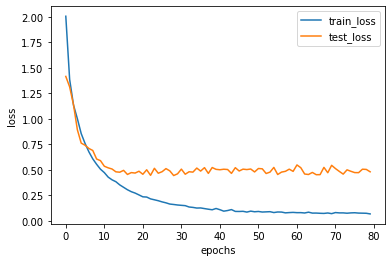

09/24 03:03:48 PM epoch 81
09/24 03:03:48 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

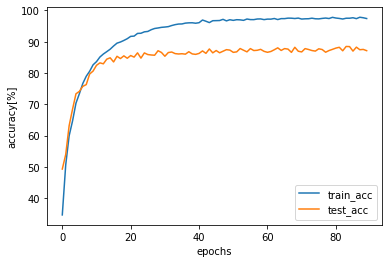

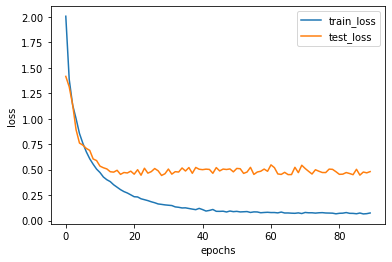

09/24 03:32:01 PM epoch 91
09/24 03:32:01 PM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 

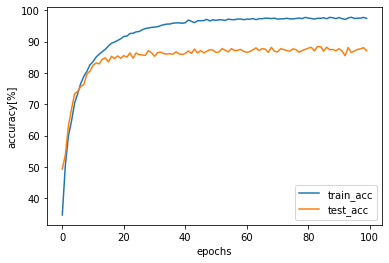

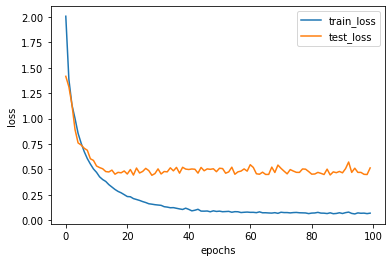

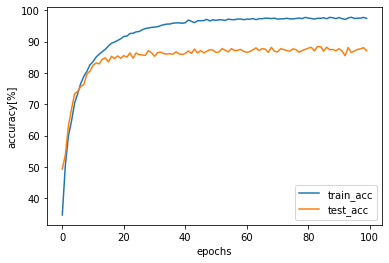

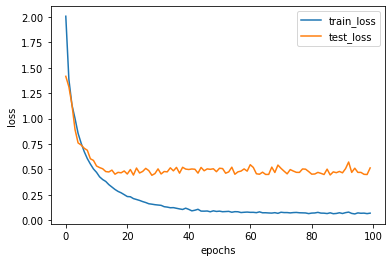

In [ ]:
if __name__ == '__main__':
  args = {'gene':'VGG19', 'stride_max':2}
  model = load_model(dir="exp_vgg19-2020-09-24_15-22-36", **args)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  main(save="exp_vgg19_eval", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       seed=41, report=100, checkpoint=10, dir="", graph=graph, **args)
  

Experiment dir : exp_eval_max-2020-09-24_10-18-06
09/24 01:18:06 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=100, graph=<networkx.classes.digraph.DiGraph object at 0x7f92b0e93240>, lr=0.01, lr_alpha=0.0, momentum=0.9, report=100, save='exp_eval_max-2020-09-24_10-18-06', seed=41, test_size=5000, train_size=25000, valid_size=25000)
09/24 01:18:06 AM gene [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
Files already downloaded and verified
Files already downloaded and verified
09/24 01:18:08 AM epoch 1
09/24 01:18:08 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
0

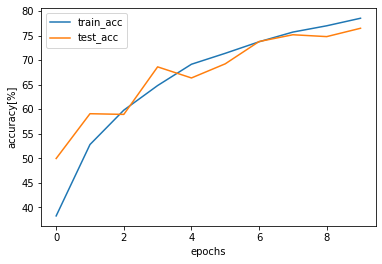

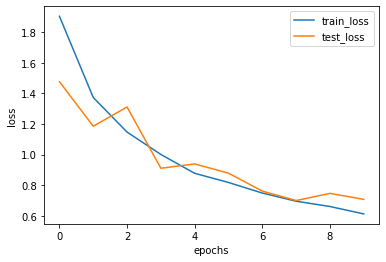

09/24 01:30:35 AM epoch 11
09/24 01:30:35 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 01:30:35 AM train 000 5.760037e-01 81.250000 98.437500
09/24 01:30:55 AM train 100 5.784942e-01 80.074257 99.071782
09/24 01:31:15 AM train 200 5.914032e-01 79.329913 99.028296
09/24 01:31:34 AM train 300 5.918762e-01 79.220307 98.987749
09/24 01:31:51 AM train_acc 79.332000
09/24 01:31:51 AM valid 000 7.944188e-01 78.125000 96.875000
09/24 01:31:53 AM valid_acc 77.900000
09/24 01:31:53 AM epoch 12
09/24 01:31:53 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0.

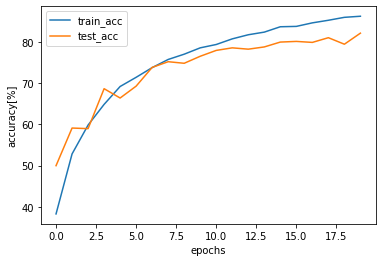

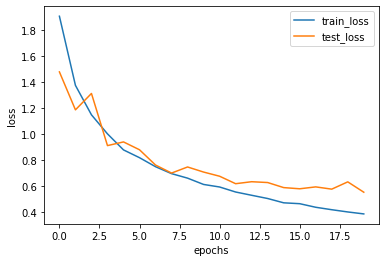

09/24 01:43:07 AM epoch 21
09/24 01:43:07 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 01:43:07 AM train 000 5.121554e-01 85.937500 98.437500
09/24 01:43:26 AM train 100 3.621823e-01 87.082302 99.597772
09/24 01:43:44 AM train 200 3.754295e-01 86.955846 99.541356
09/24 01:44:02 AM train 300 3.706201e-01 87.043189 99.563953
09/24 01:44:18 AM train_acc 86.772000
09/24 01:44:19 AM valid 000 6.261585e-01 76.562500 100.000000
09/24 01:44:20 AM valid_acc 80.680000
09/24 01:44:20 AM epoch 22
09/24 01:44:20 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0

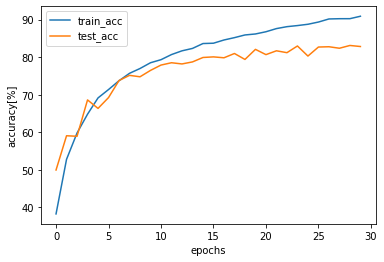

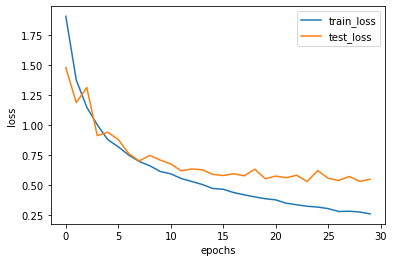

09/24 01:55:40 AM epoch 31
09/24 01:55:40 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 01:55:40 AM train 000 1.658825e-01 95.312500 100.000000
09/24 01:56:00 AM train 100 2.436875e-01 91.769802 99.845297
09/24 01:56:18 AM train 200 2.378352e-01 91.845460 99.852301
09/24 01:56:37 AM train 300 2.451120e-01 91.414037 99.865033
09/24 01:56:53 AM train_acc 91.056000
09/24 01:56:53 AM valid 000 6.044008e-01 82.812500 96.875000
09/24 01:56:54 AM valid_acc 83.440000
09/24 01:56:54 AM epoch 32
09/24 01:56:54 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0

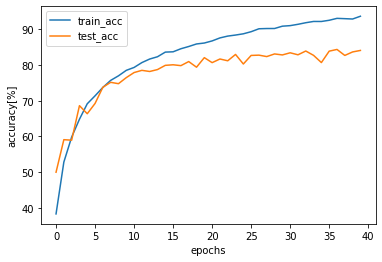

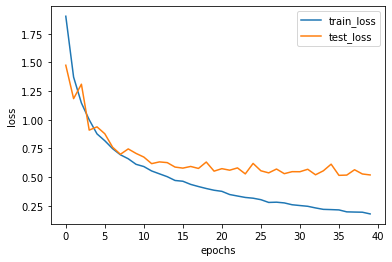

09/24 02:08:07 AM epoch 41
09/24 02:08:07 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 02:08:07 AM train 000 1.494629e-01 95.312500 100.000000
09/24 02:08:29 AM train 100 1.723307e-01 93.873762 99.984530
09/24 02:08:50 AM train 200 1.753336e-01 93.555659 99.961132
09/24 02:09:10 AM train 300 1.792154e-01 93.474875 99.958472
09/24 02:09:28 AM train_acc 93.332000
09/24 02:09:28 AM valid 000 6.258577e-01 84.375000 100.000000
09/24 02:09:29 AM valid_acc 83.660000
09/24 02:09:29 AM epoch 42
09/24 02:09:29 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 

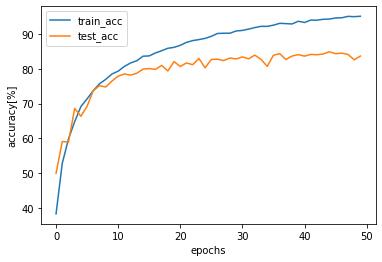

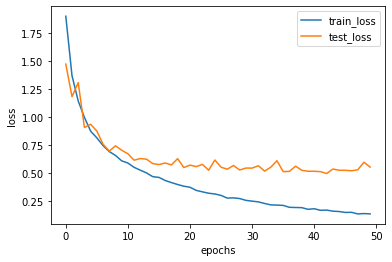

09/24 02:20:30 AM epoch 51
09/24 02:20:30 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 02:20:31 AM train 000 2.068150e-01 95.312500 100.000000
09/24 02:20:51 AM train 100 1.363459e-01 95.235149 99.984530
09/24 02:21:09 AM train 200 1.409014e-01 95.055970 99.976679
09/24 02:21:27 AM train 300 1.414463e-01 95.042566 99.974045
09/24 02:21:44 AM train_acc 94.976000
09/24 02:21:44 AM valid 000 6.286414e-01 81.250000 98.437500
09/24 02:21:45 AM valid_acc 83.600000
09/24 02:21:45 AM epoch 52
09/24 02:21:45 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0

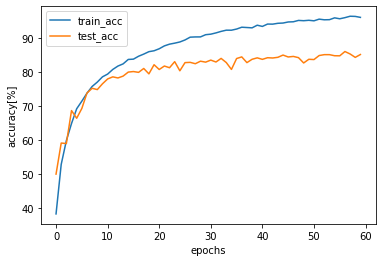

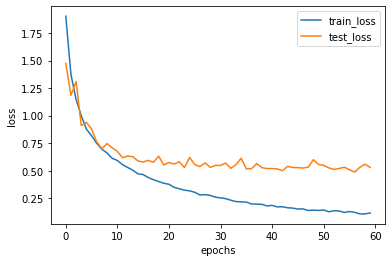

09/24 02:32:54 AM epoch 61
09/24 02:32:54 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 02:32:54 AM train 000 1.079172e-01 95.312500 100.000000
09/24 02:33:14 AM train 100 1.160675e-01 96.008663 99.984530
09/24 02:33:34 AM train 200 1.170393e-01 95.973259 99.976679
09/24 02:33:52 AM train 300 1.215397e-01 95.836794 99.979236
09/24 02:34:08 AM train_acc 95.704000
09/24 02:34:08 AM valid 000 5.386397e-01 87.500000 100.000000
09/24 02:34:09 AM valid_acc 84.880000
09/24 02:34:09 AM epoch 62
09/24 02:34:09 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 

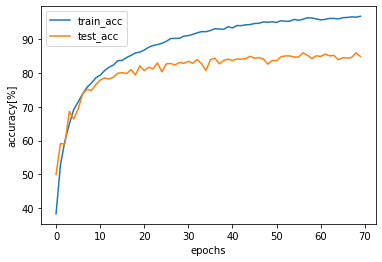

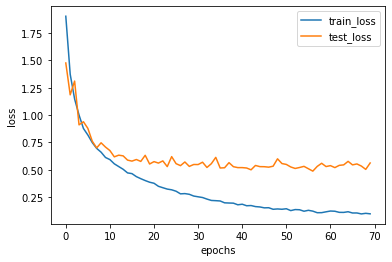

09/24 02:45:23 AM epoch 71
09/24 02:45:23 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 02:45:23 AM train 000 1.753070e-01 92.187500 100.000000
09/24 02:45:43 AM train 100 9.175129e-02 96.720297 100.000000
09/24 02:46:03 AM train 200 9.523215e-02 96.742848 100.000000
09/24 02:46:23 AM train 300 1.017689e-01 96.542774 99.994809
09/24 02:46:41 AM train_acc 96.368000
09/24 02:46:41 AM valid 000 4.999741e-01 81.250000 100.000000
09/24 02:46:42 AM valid_acc 85.260000
09/24 02:46:42 AM epoch 72
09/24 02:46:42 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0.

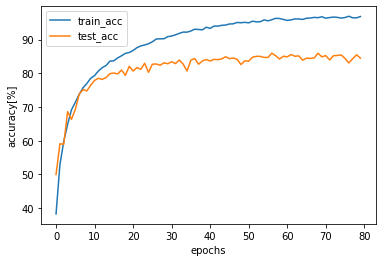

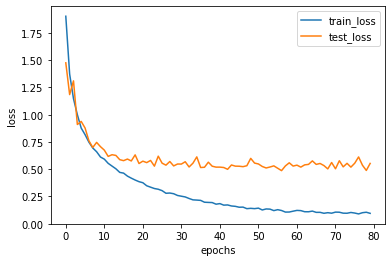

09/24 02:57:58 AM epoch 81
09/24 02:57:58 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 02:57:58 AM train 000 1.267564e-01 96.875000 100.000000
09/24 02:58:19 AM train 100 9.156325e-02 96.890470 100.000000
09/24 02:58:39 AM train 200 9.057935e-02 96.836132 100.000000
09/24 02:58:59 AM train 300 9.198392e-02 96.791944 100.000000
09/24 02:59:17 AM train_acc 96.616000
09/24 02:59:17 AM valid 000 5.656050e-01 87.500000 98.437500
09/24 02:59:18 AM valid_acc 85.120000
09/24 02:59:18 AM epoch 82
09/24 02:59:18 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0.

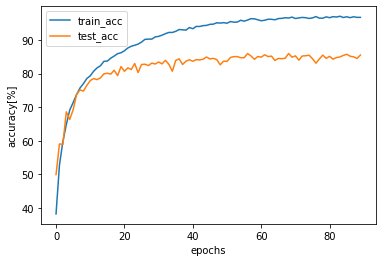

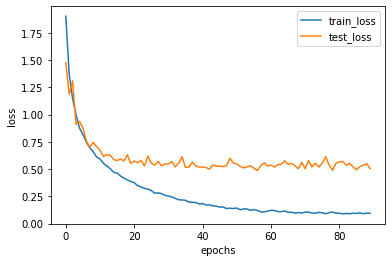

09/24 03:10:18 AM epoch 91
09/24 03:10:18 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
09/24 03:10:18 AM train 000 5.300703e-02 100.000000 100.000000
09/24 03:10:38 AM train 100 7.145058e-02 97.617574 99.984530
09/24 03:10:58 AM train 200 7.859041e-02 97.294776 99.992226
09/24 03:11:17 AM train 300 7.723426e-02 97.399294 99.989618
09/24 03:11:33 AM train_acc 97.296000
09/24 03:11:33 AM valid 000 7.035444e-01 82.812500 98.437500
09/24 03:11:34 AM valid_acc 84.640000
09/24 03:11:34 AM epoch 92
09/24 03:11:34 AM alpha tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 

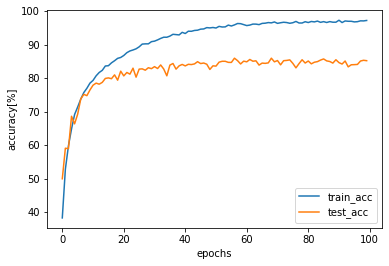

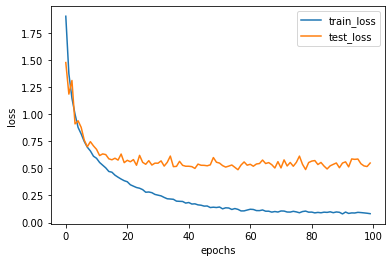

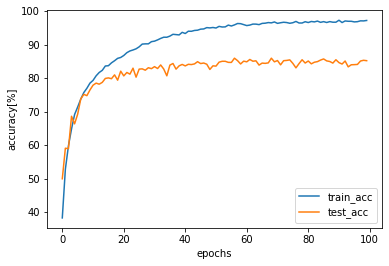

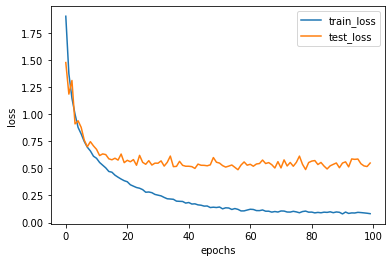

In [ ]:
if __name__ == '__main__':
  model = load_model(dir="exp-2020-09-24_08-53-44")
  
  # sampler : ArchitectureSampler = ForwardSampler()
  # graph = model.sampled_graph(sampler)
  # main(save="exp_eval_forward", lr=0.01, momentum=0.9, lr_alpha=0.0, epochs=100, 
  #     train_size=25000, valid_size=25000, test_size=5000, batch_size=64, 
  #     seed=41, report=100, checkpoint=10, dir="", graph=graph)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  main(save="exp_eval_max", lr=0.01, momentum=0.9, lr_alpha=0.0, epochs=100, 
      train_size=25000, valid_size=25000, test_size=5000, batch_size=64, 
      seed=41, report=100, checkpoint=10, dir="", graph=graph)
  

# exp

TODO
- watch model size, memory
- early stopping